In [60]:
from darts.datasets import AirPassengersDataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

series = AirPassengersDataset().load()
series.pd_dataframe()

component,#Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
...,...
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,461.0


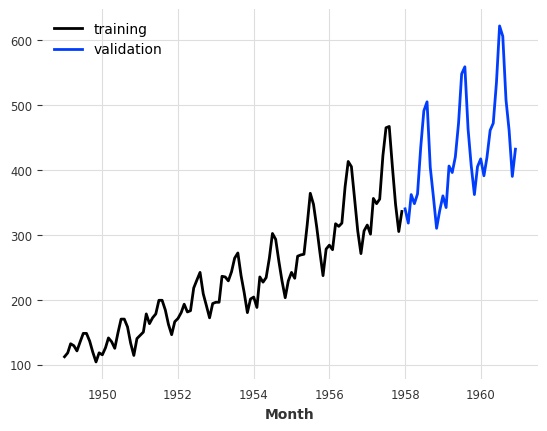

In [2]:
train, val = series.split_before(pd.Timestamp("19580101"))
train.plot(label="training")
val.plot(label="validation");

<Axes: xlabel='Month'>

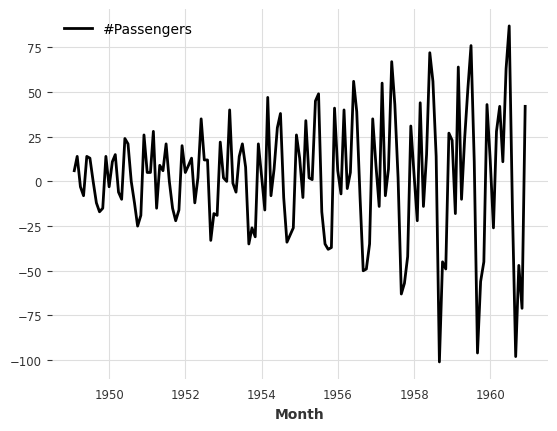

In [3]:
series.diff().plot()

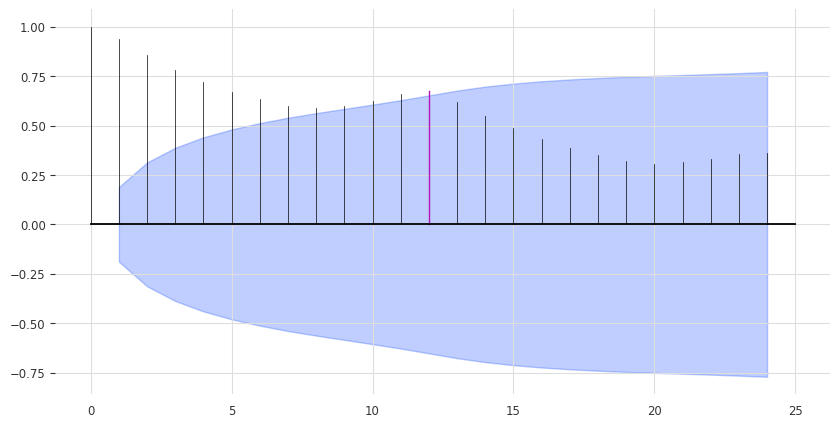

In [4]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, m=12, alpha=0.05)

<Axes: xlabel='Month'>

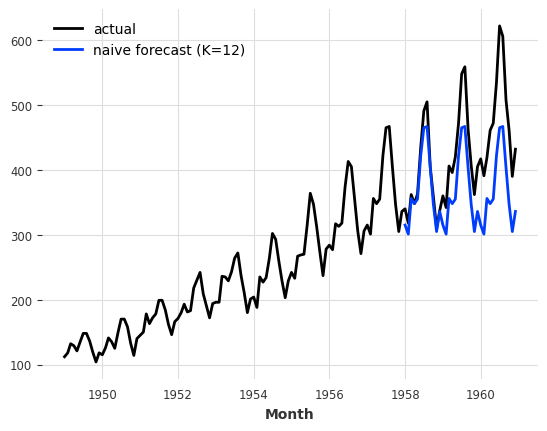

In [5]:
from darts.models import NaiveSeasonal

seasonal_model = NaiveSeasonal(K=12)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(36)

series.plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=12)")

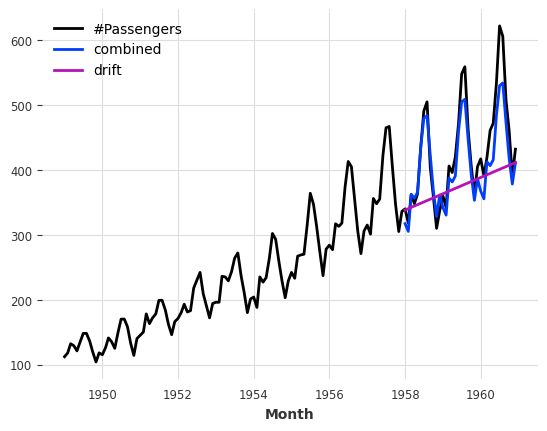

In [6]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(36)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift");


In [7]:
from darts.metrics import mape

print(
    "Mean absolute percentage error for the combined naive drift + seasonal: {:.2f}%.".format(
        mape(series, combined_forecast)
    )
)

Mean absolute percentage error for the combined naive drift + seasonal: 5.66%.


In [8]:
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta


def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(val, forecast)))


eval_model(ExponentialSmoothing())
eval_model(TBATS())
eval_model(AutoARIMA())
eval_model(Theta())

model ExponentialSmoothing() obtains MAPE: 5.11%
model TBATS() obtains MAPE: 5.87%
model AutoARIMA() obtains MAPE: 11.65%
model Theta() obtains MAPE: 8.15%


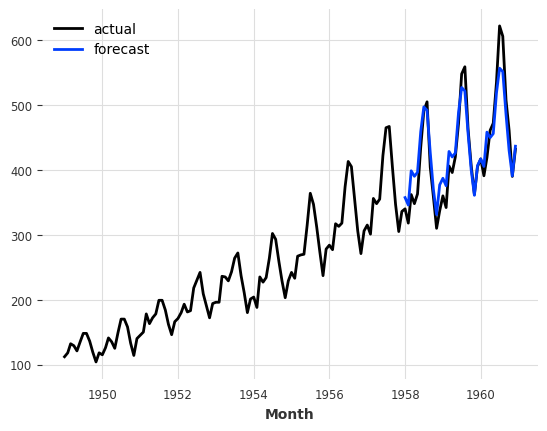

In [9]:
model = ExponentialSmoothing()
model.fit(train)
forecast = model.predict(36)
series.plot(label="actual")
forecast.plot(label="forecast");


  0%|          | 0/57 [00:00<?, ?it/s]

MAPE = 4.45%


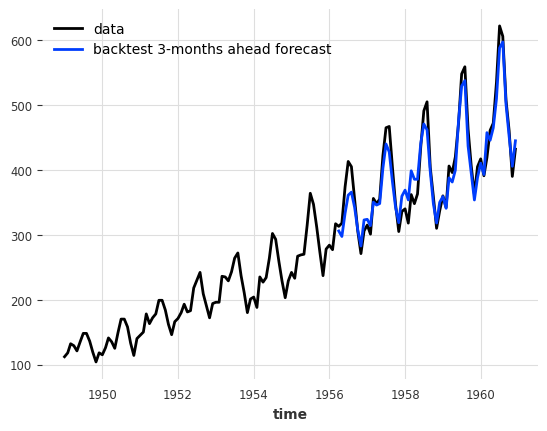

In [11]:
historical_fcast_theta = model.historical_forecasts(
    series, start=0.6, forecast_horizon=3, verbose=True
)

series.plot(label="data")
historical_fcast_theta.plot(label="backtest 3-months ahead forecast")
print("MAPE = {:.2f}%".format(mape(historical_fcast_theta, series)))

  0%|          | 0/57 [00:00<?, ?it/s]

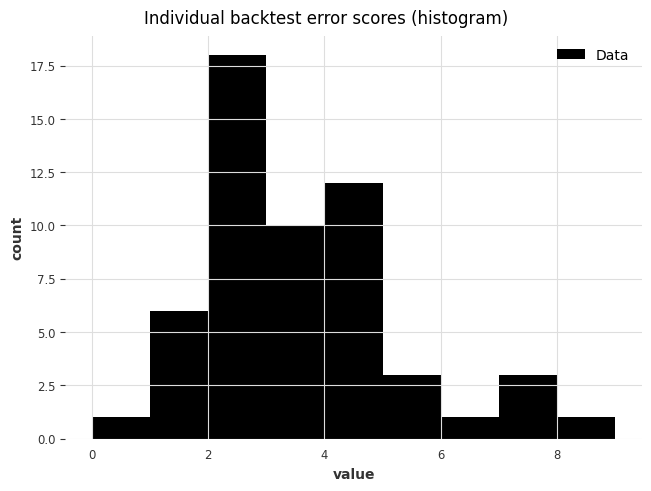

In [12]:
raw_errors = model.backtest(
    series, start=0.6, forecast_horizon=3, metric=mape, reduction=None, verbose=True
)

from darts.utils.statistics import plot_hist

plot_hist(
    raw_errors,
    bins=np.arange(0, max(raw_errors), 1),
    title="Individual backtest error scores (histogram)",
)

In [13]:
average_error = model.backtest(
    series,
    start=0.6,
    forecast_horizon=3,
    metric=mape,
    reduction=np.mean,  # this is actually the default
    verbose=True,
)

print("Average error (MAPE) over all historical forecasts: %.2f" % average_error)

  0%|          | 0/57 [00:00<?, ?it/s]

Average error (MAPE) over all historical forecasts: 3.81


# Models

In [6]:
from darts.models import RegressionModel
from darts.models.forecasting.forecasting_model import GlobalForecastingModel

supports_multi_ts = issubclass(RegressionModel, GlobalForecastingModel)
supports_multi_ts

True

# My Own Series

The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.


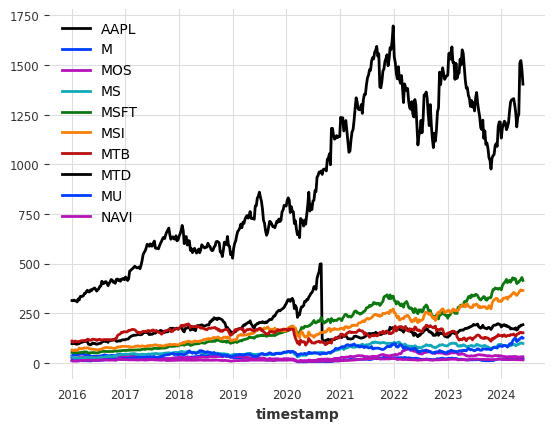

In [37]:

from darts.timeseries import TimeSeries

closes = pd.read_csv('../raw_data/closes.csv', index_col='timestamp', parse_dates=True)
series = TimeSeries.from_dataframe(closes).astype(np.float32)
series.plot();

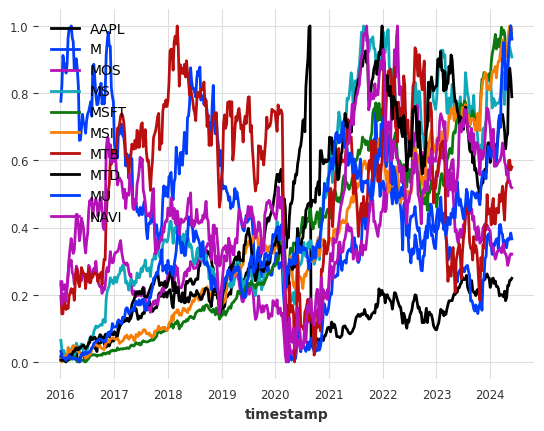

In [43]:
from darts.dataprocessing.transformers import Scaler

scaler = Scaler()
series_scaled = scaler.fit_transform(series)

series_scaled.plot();

<Axes: xlabel='timestamp'>

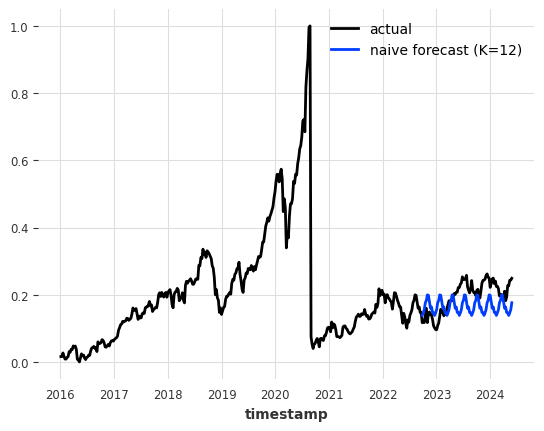

In [46]:
#apple = TimeSeries.from_series(closes['AAPL']).astype(np.float32)
apple = series_scaled.univariate_component('AAPL')
train, val = apple.split_after(0.8)

seasonal_model = NaiveSeasonal(K=12)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(len(val))

apple.plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=12)")

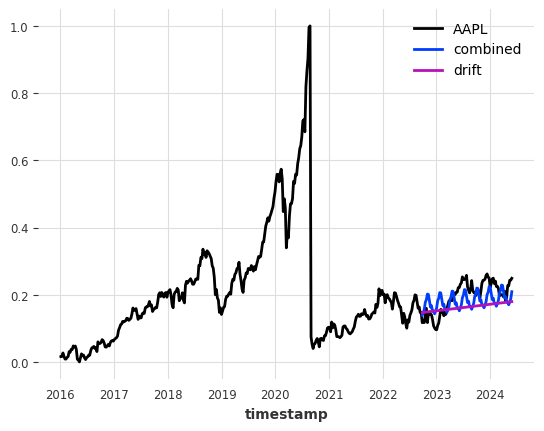

In [47]:
drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(len(val))

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

apple.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift");

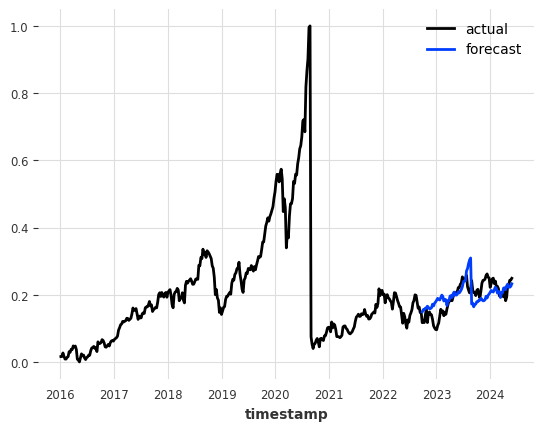

In [48]:
model = ExponentialSmoothing()
model.fit(train)
forecast = model.predict(len(val))
apple.plot(label="actual")
forecast.plot(label="forecast");

In [56]:
from darts.models import RegressionModel
from sklearn.linear_model import BayesianRidge

model = RegressionModel(lags=72, model=BayesianRidge())
train, val = series_scaled.split_after(0.8)

model.fit(
    train
);

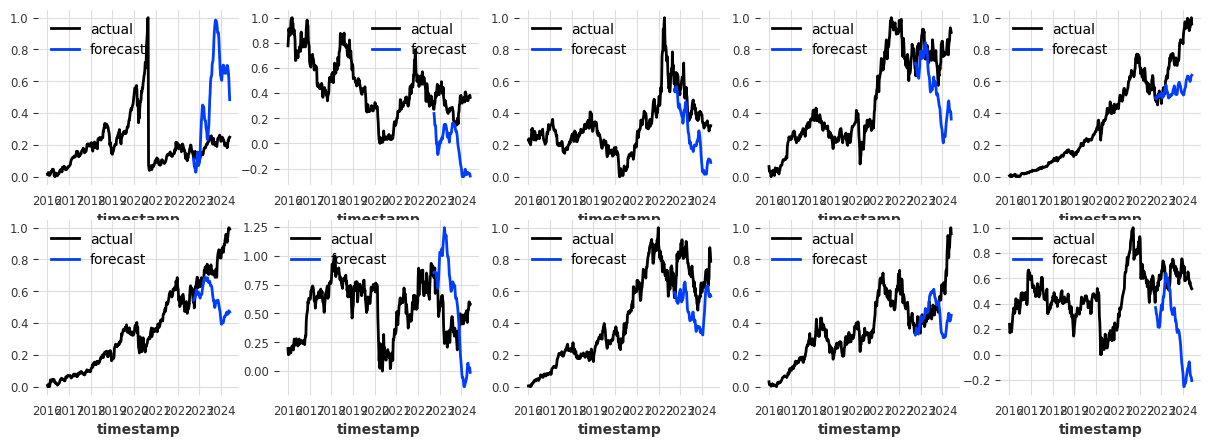

In [62]:
fig, axs = plt.subplots(2, 5, figsize=(15, 5))

for i, ax in enumerate(axs.ravel()):
    forecast = model.predict(len(val))
    series_scaled.univariate_component(i).plot(label="actual", ax=ax)
    forecast.univariate_component(i).plot(label="forecast", ax=ax);